ARIMA Testing

In [51]:
import datetime
import yfinance as yf
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
from sklearn.model_selection import TimeSeriesSplit

In [52]:
# Load stock data for a particular ticker
ticker = "PNM"

# Get today's date
today = datetime.datetime.now()

# Subtract one day to get yesterday's date
yesterday = today - datetime.timedelta(days=1)

# Format yesterday's date as a string in yyyy-mm-dd format
yesterday_str = yesterday.strftime("%Y-%m-%d")

raw_data = yf.download(ticker, start="2010-01-01", end=yesterday_str, interval='1d')

[*********************100%***********************]  1 of 1 completed


<Axes: title={'center': 'Adjusted Closing Prices'}, xlabel='Date'>

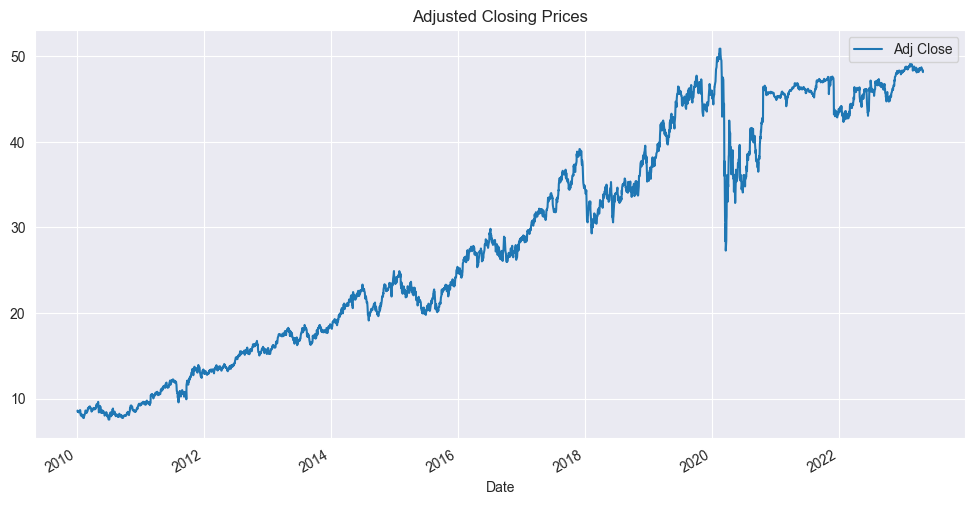

In [53]:
# Create a copy of the raw_data
data = raw_data.copy()

# Take the adjusted close price column
data = data[['Adj Close']]

# Visualize the time series to check for stationarity
data.plot(figsize=(12, 6), title='Adjusted Closing Prices')

In [54]:
# test if stationary
result = adfuller(data['Adj Close'])
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
print('Critical Values:')
for key, value in result[4].items():
    print(f'   {key}: {value}')

ADF Statistic: -0.8650847060359725
p-value: 0.7992530250669968
Critical Values:
   1%: -3.432314089126596
   5%: -2.8624078194221996
   10%: -2.567231957694242


<Axes: title={'center': 'Differenced Adjusted Closing Prices'}, xlabel='Date'>

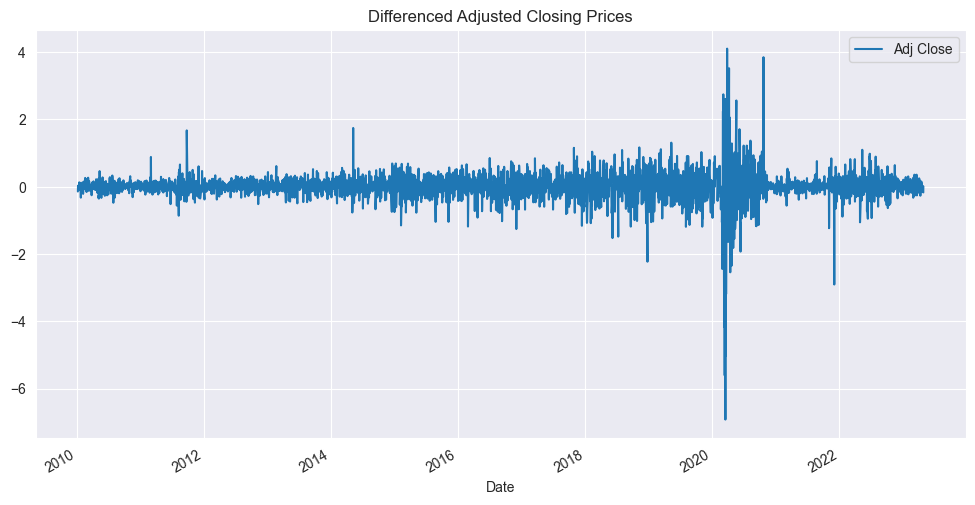

In [55]:
# Difference the time series to make it stationary
data_diff = data.diff().dropna()

# Visualize the differenced time series to check for stationarity
data_diff.plot(figsize=(12, 6), title='Differenced Adjusted Closing Prices')

In [56]:
# Test for stationarity
result = adfuller(data_diff['Adj Close'])
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
print('Critical Values:')
for key, value in result[4].items():
    print(f'   {key}: {value}')

ADF Statistic: -15.337238769954233
p-value: 3.874002889875358e-28
Critical Values:
   1%: -3.432314089126596
   5%: -2.8624078194221996
   10%: -2.567231957694242


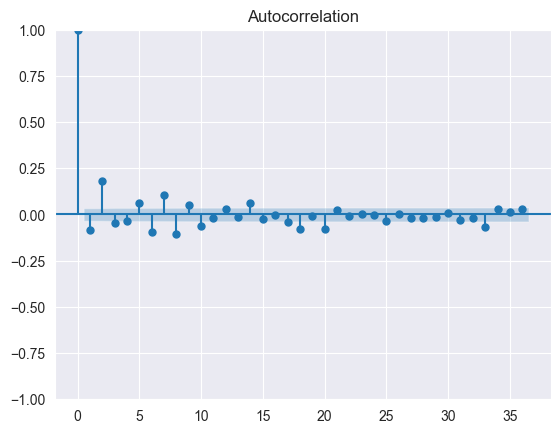

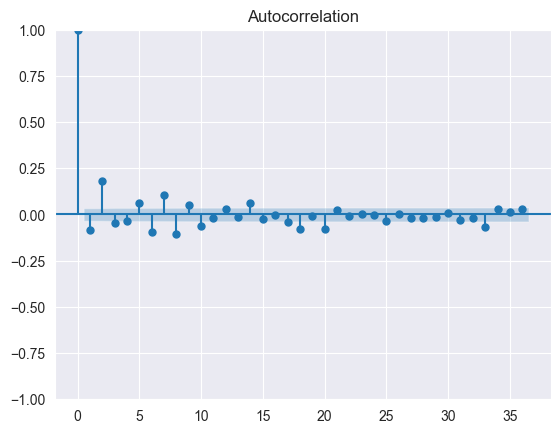

In [57]:
# Plot ACF and PACF to identify the p, d, and q parameters for the ARIMA model
plot_acf(data_diff)

/Users/jake/PycharmProjects/pythonProject2/venv/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


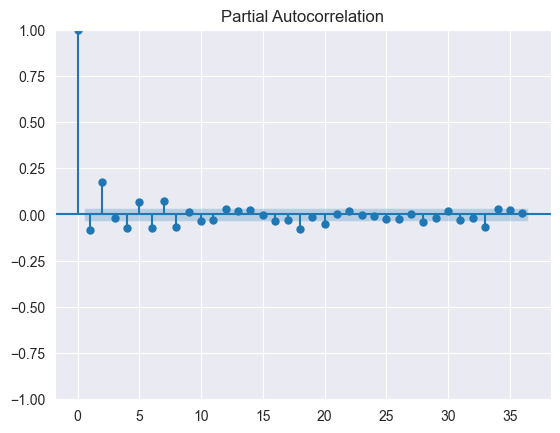

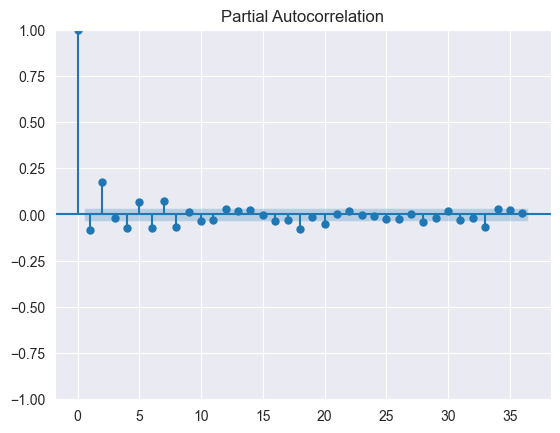

In [58]:
plot_pacf(data_diff)

In [59]:
# Train the ARIMA model with the identified parameters
model = ARIMA(data, order=(1, 1, 1))
results = model.fit()

# Generate the forecast for the next 30 days
forecast = results.forecast(steps=30)

forecast

/Users/jake/PycharmProjects/pythonProject2/venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/jake/PycharmProjects/pythonProject2/venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/jake/PycharmProjects/pythonProject2/venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/jake/PycharmProjects/pythonProject2/venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported 

3353    48.152982
3354    48.139687
3355    48.147378
3356    48.142928
3357    48.145503
3358    48.144013
3359    48.144875
3360    48.144377
3361    48.144665
3362    48.144498
3363    48.144595
3364    48.144539
3365    48.144571
3366    48.144552
3367    48.144563
3368    48.144557
3369    48.144561
3370    48.144559
3371    48.144560
3372    48.144559
3373    48.144559
3374    48.144559
3375    48.144559
3376    48.144559
3377    48.144559
3378    48.144559
3379    48.144559
3380    48.144559
3381    48.144559
3382    48.144559
Name: predicted_mean, dtype: float64

In [60]:
# Specify the number of splits for cross-validation
n_splits = 5

# Create a time series split object
tscv = TimeSeriesSplit(n_splits=n_splits)

# Create a list to store the evaluation metrics for each fold
mae_scores = []
mse_scores = []
rmse_scores = []
r2_scores = []
aic_scores = []

for train_index, test_index in tscv.split(data):
    # Split the data into training and test sets based on the time series split
    data_train, data_test = data.iloc[train_index], data.iloc[test_index]

    # Train the ARIMA model on the training set
    model = ARIMA(data_train, order=(1, 1, 1))
    results = model.fit()

    # Generate forecast for the test set
    forecast = results.forecast(steps=len(data_test))

    # Evaluate the performance of the model using different metrics and store in the respective lists
    mae_scores.append(mean_absolute_error(data_test, forecast))
    mse_scores.append(mean_squared_error(data_test, forecast))
    rmse_scores.append(mean_squared_error(data_test, forecast, squared=False))
    r2_scores.append(r2_score(data_test, forecast))
    aic_scores.append(results.aic)

# Print the evaluation metrics for each fold
print(f'MAE Scores: {mae_scores}')
print(f'MSE Scores: {mse_scores}')
print(f'RMSE Scores: {rmse_scores}')
print(f'R2 Scores: {r2_scores}')
print(f'AIC Scores: {aic_scores}')

# Print the average scores across all folds
print(f'Average MAE Score: {np.mean(mae_scores)}')
print(f'Average MSE Score: {np.mean(mse_scores)}')
print(f'Average RMSE Score: {np.mean(rmse_scores)}')
print(f'Average R2 Score: {np.mean(r2_scores)}')
print(f'Average AIC Score: {np.mean(aic_scores)}')

/Users/jake/PycharmProjects/pythonProject2/venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/jake/PycharmProjects/pythonProject2/venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/jake/PycharmProjects/pythonProject2/venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/jake/PycharmProjects/pythonProject2/venv/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-statio

MAE Scores: [3.4633547405766496, 2.2451761552925498, 6.124871527835898, 5.111936635836714, 1.3208466035175668]
MSE Scores: [16.91417664302684, 8.64390313377631, 47.22868822742357, 37.24384355949767, 2.712304575680753]
RMSE Scores: [4.112684846061857, 2.940051552911328, 6.872313164242704, 6.102773431768352, 1.6469075795808195]
R2 Scores: [-2.300519353067361, -0.25426386629265574, -3.8097145527480194, -0.9738710635723313, -0.07921882952462989]
AIC Scores: [-314.7295368340382, -527.7967955861619, -100.49225427322722, 689.9387496599024, 3508.563236862019]
Average MAE Score: 3.6532371326118755
Average MSE Score: 22.54858322788103
Average RMSE Score: 4.334946114913012
Average R2 Score: -1.4835175330409995
Average AIC Score: 651.0966799656987


/Users/jake/PycharmProjects/pythonProject2/venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
